In [2]:
import pandas as pd
import os
import librosa
import librosa.display
import pytumblr

In [3]:
import struct

class WavFileHelper():
    
    def read_file_properties(self, filename):

        wave_file = open(filename,"rb")
        
        riff = wave_file.read(12)
        fmt = wave_file.read(36)
        
        num_channels_string = fmt[10:12]
        num_channels = struct.unpack('<H', num_channels_string)[0]

        sample_rate_string = fmt[12:16]
        sample_rate = struct.unpack("<I",sample_rate_string)[0]
        
        bit_depth_string = fmt[22:24]
        bit_depth = struct.unpack("<H",bit_depth_string)[0]

        return (num_channels, sample_rate, bit_depth)

In [4]:
wavfilehelper = WavFileHelper()

audiodata = []
Datadir = "C:/Users/Master/Desktop/Sound_Class/"
CATEGORIES = ["A", "B", "C", "D"]
file_size = ['1', '2', '3', '4', '5','6']
for category in CATEGORIES:
    path = os.path.join(Datadir, category)
    for wav in os.listdir(path):
        for position in file_size:
            data = wavfilehelper.read_file_properties(path+'/'+position+'.wav')
            audiodata.append(data)
    
# Convert into a Panda dataframe
audiodf = pd.DataFrame(audiodata, columns=['num_channels','sample_rate','bit_depth'])

In [5]:
print(audiodf.num_channels.value_counts(normalize=True))

2    1.0
Name: num_channels, dtype: float64


In [6]:
print(audiodf.sample_rate.value_counts(normalize=True))

44100    1.0
Name: sample_rate, dtype: float64


In [7]:
print(audiodf.bit_depth.value_counts(normalize=True))

16    1.0
Name: bit_depth, dtype: float64


In [8]:
# start of mechine learning


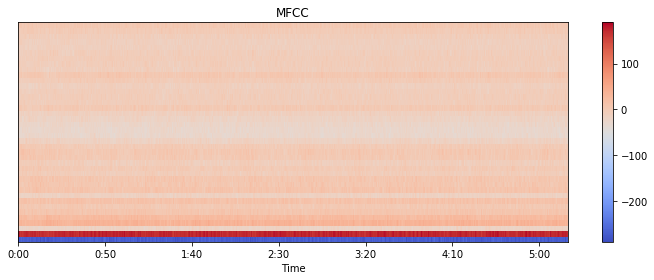

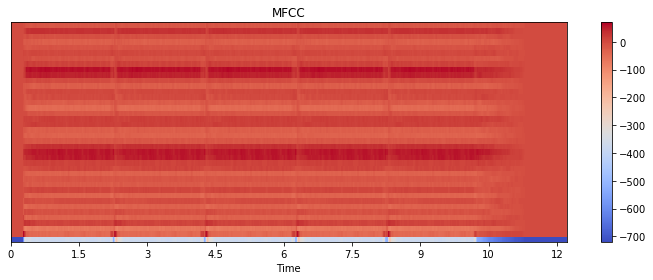

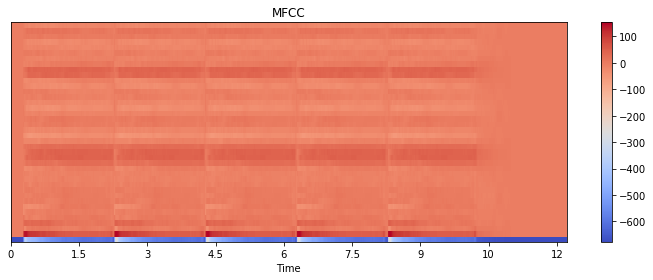

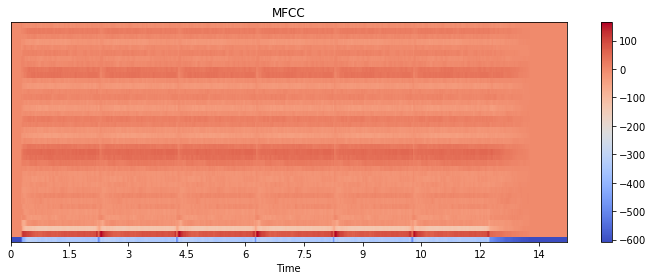

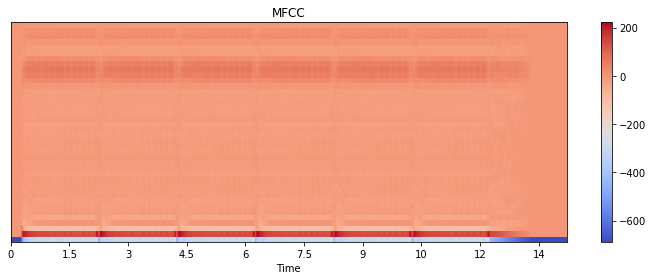

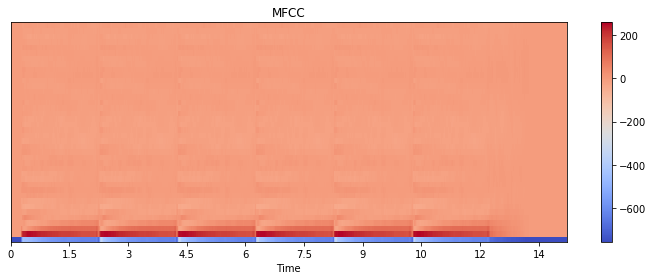

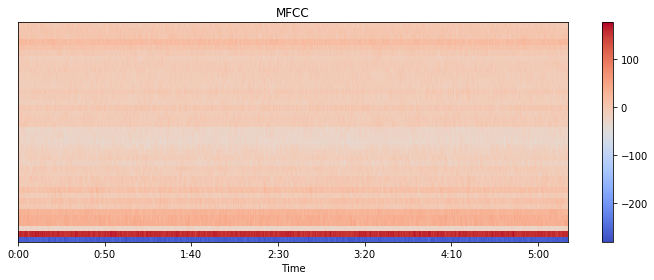

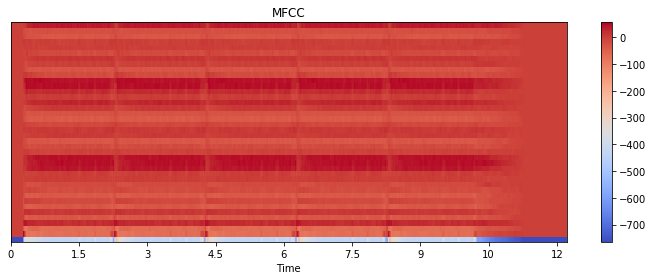

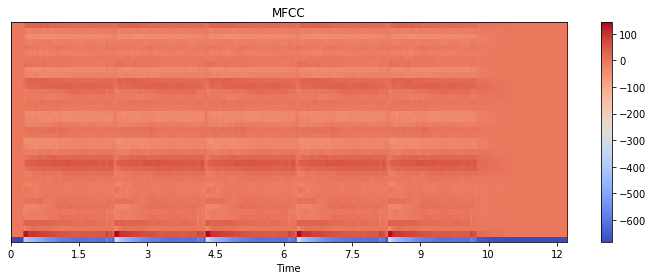

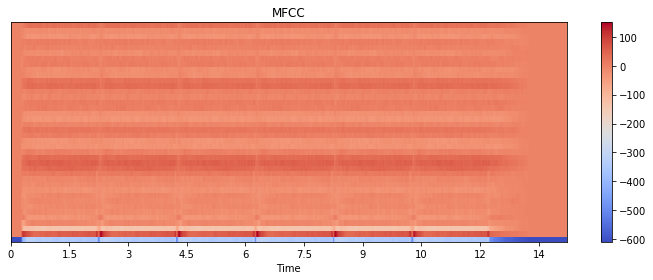

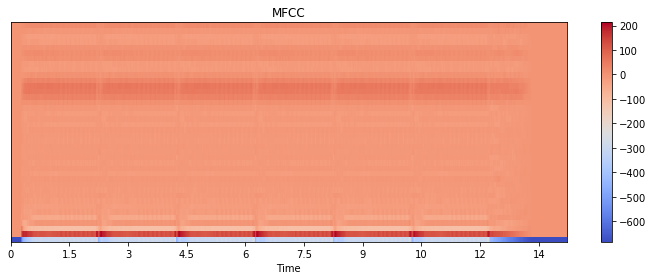

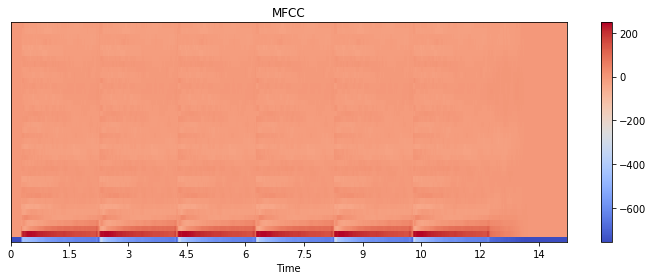

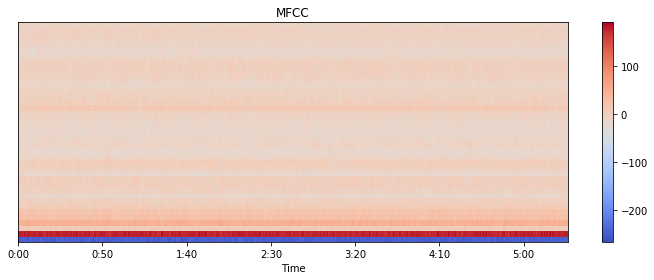

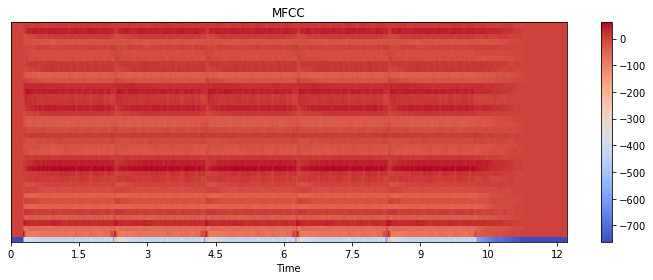

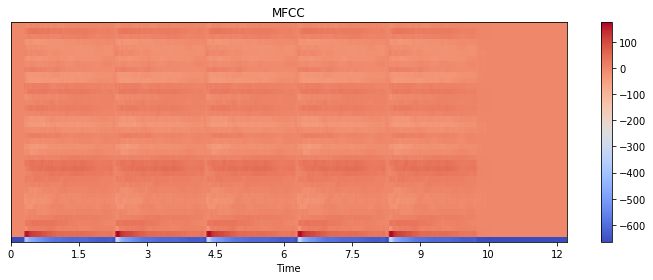

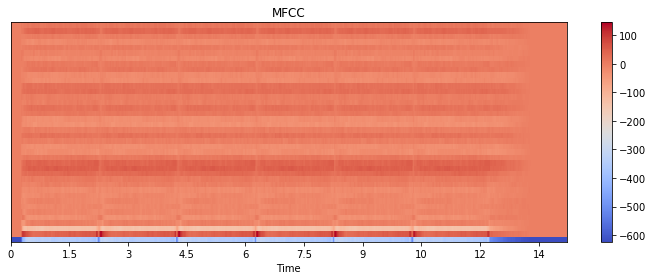

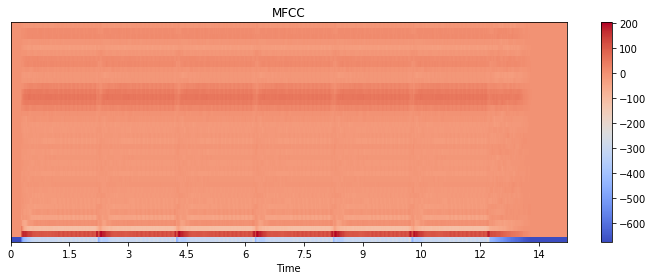

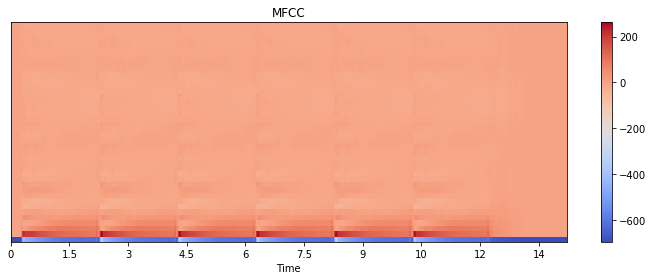

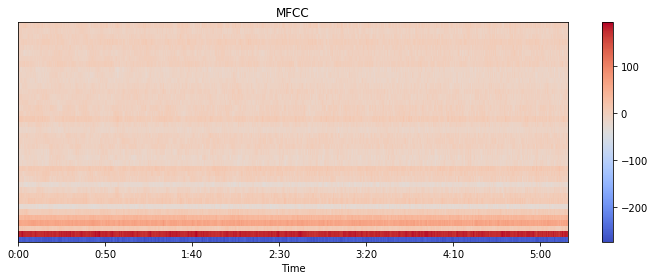

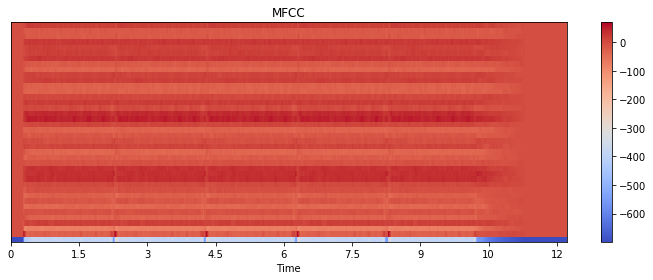

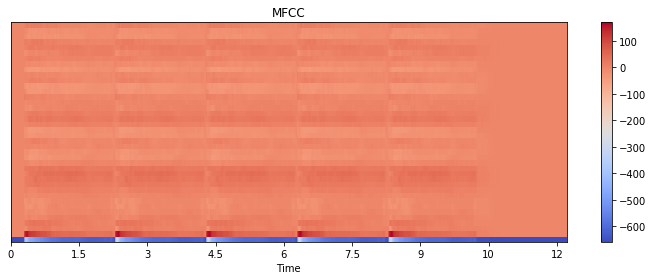

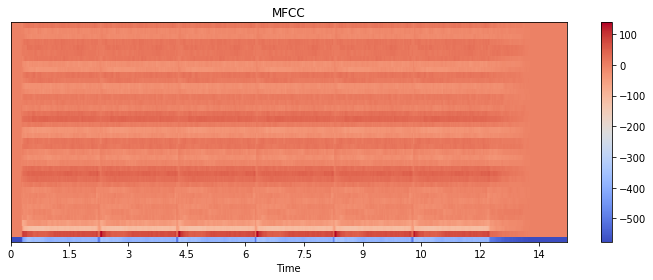

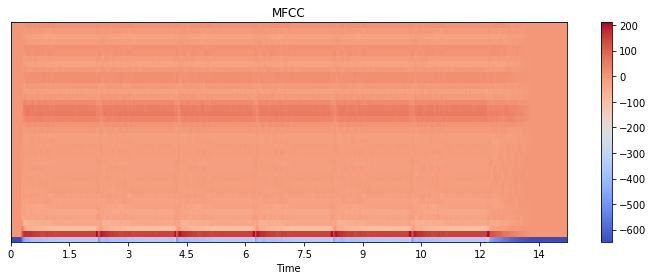

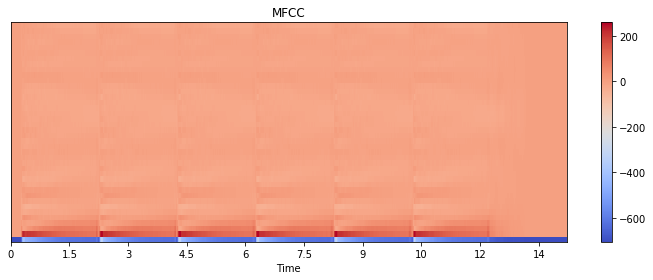

Finished feature extraction from  24  files


In [9]:
def extract_features(file_name):
   
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccsscaled = np.mean(mfccs.T,axis=0)
        import matplotlib.pyplot as plt
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(mfccs, x_axis='time')
        plt.colorbar()
        plt.title('MFCC')
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print("Error encountered while parsing file: ", file)
        return None 
     
    return mfccsscaled
    
    
# Load various imports 
import pandas as pd
import os
import librosa
import numpy as np
# Set the path to the full UrbanSound dataset 
fulldatasetpath = 'C:/Users/Master/Desktop/Sound_Class/'

metadata = pd.read_csv(fulldatasetpath + '/SoundFiles.csv')

features = []

# Iterate through each sound file and extract the features 
for index, row in metadata.iterrows():

    file_name = os.path.join(os.path.abspath(fulldatasetpath+str(row["file"])))
    
    class_label = row["class_label"]
    data = extract_features(file_name)
    
    features.append([data, class_label])

# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

print('Finished feature extraction from ', len(featuresdf), ' files')

In [10]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y)) 

# split the dataset 
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)

Using TensorFlow backend.


In [17]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 
import time

NAME = "Sound-cnn-{}".format(int(time.time()))

tensorboard = TensorBoard(log_dir="./logs/{}".format(NAME))

num_rows = 10
num_columns = 4
num_channels = 1

x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)

num_labels = yy.shape[1]
filter_size = 2

# Construct model 
model = Sequential()
#model.add(Conv2D(filters=16,kernel_size=2, input_shape=(num_rows, num_columns, num_channels), activation='relu'))
#model.add(MaxPooling2D(pool_size=(2,2)))

#model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
#model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))


#model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
#model.add(MaxPooling2D(pool_size=(2,2)))

model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax'))

In [19]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

from tensorflow.keras.callbacks import TensorBoard
from datetime import datetime 

num_epochs = 72
num_batch_size = 256

model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), callbacks=[tensorboard], verbose=1)

model.save('Sound-CNN.model')

print("Training completed in time: ")

# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy) 

Train on 19 samples, validate on 5 samples
Epoch 1/72
19/19 [==============================] - 0s 11ms/step - loss: 0.5659 - acc: 0.8421 - val_loss: 3.5741 - val_acc: 0.0000e+00
Epoch 2/72
19/19 [==============================] - 0s 105us/step - loss: 0.6899 - acc: 0.7368 - val_loss: 3.5414 - val_acc: 0.0000e+00
Epoch 3/72
19/19 [==============================] - 0s 158us/step - loss: 0.5542 - acc: 0.8421 - val_loss: 3.8213 - val_acc: 0.2000
Epoch 4/72
19/19 [==============================] - 0s 105us/step - loss: 0.6248 - acc: 0.8421 - val_loss: 3.9074 - val_acc: 0.2000
Epoch 5/72
19/19 [==============================] - 0s 105us/step - loss: 0.6122 - acc: 0.7895 - val_loss: 3.8506 - val_acc: 0.0000e+00
Epoch 6/72
19/19 [==============================] - 0s 105us/step - loss: 0.5553 - acc: 0.8421 - val_loss: 3.7894 - val_acc: 0.0000e+00
Epoch 7/72
19/19 [==============================] - 0s 105us/step - loss: 0.5312 - acc: 0.8421 - val_loss: 3.7387 - val_acc: 0.0000e+00
Epoch 8/72
19/

Epoch 61/72
19/19 [==============================] - 0s 105us/step - loss: 0.3147 - acc: 1.0000 - val_loss: 4.8344 - val_acc: 0.0000e+00
Epoch 62/72
19/19 [==============================] - 0s 158us/step - loss: 0.3119 - acc: 1.0000 - val_loss: 4.8637 - val_acc: 0.0000e+00
Epoch 63/72
19/19 [==============================] - 0s 158us/step - loss: 0.3091 - acc: 1.0000 - val_loss: 4.8886 - val_acc: 0.0000e+00
Epoch 64/72
19/19 [==============================] - 0s 105us/step - loss: 0.3063 - acc: 1.0000 - val_loss: 4.9084 - val_acc: 0.0000e+00
Epoch 65/72
19/19 [==============================] - 0s 158us/step - loss: 0.3035 - acc: 1.0000 - val_loss: 4.9255 - val_acc: 0.0000e+00
Epoch 66/72
19/19 [==============================] - 0s 158us/step - loss: 0.3007 - acc: 1.0000 - val_loss: 4.9433 - val_acc: 0.0000e+00
Epoch 67/72
19/19 [==============================] - 0s 158us/step - loss: 0.2980 - acc: 1.0000 - val_loss: 4.9635 - val_acc: 0.0000e+00
Epoch 68/72
19/19 [======================

In [20]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  1.0
Testing Accuracy:  0.0
